In [1927]:
import os
import re
import sys
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from invisible_cities.database  import load_db
from invisible_cities.io.dst_io import load_dst
from invisible_cities.io.dst_io import df_writer
%config InlineBackend.figure_format = 'svg'

In [1875]:
# Load in the files
lt_dir = os.path.expandvars("../files/S1_temp/")
# lt_dir = os.path.expandvars("../config/")
lt_filenames = glob.glob(os.path.join(lt_dir, "*.h5"))
lt_filenames = sorted(lt_filenames)
print(lt_filenames)

# Configure the detector database
detector_db = "new"
datapmt = load_db.DataPMT(detector_db, 0)
xpmt, ypmt = datapmt["X"].values, datapmt["Y"].values
sensorids  = datapmt["SensorID"].values

['../files/S1_temp/NEW_S1_LT_1.next.h5', '../files/S1_temp/NEW_S1_LT_10.next.h5', '../files/S1_temp/NEW_S1_LT_100.next.h5', '../files/S1_temp/NEW_S1_LT_11.next.h5', '../files/S1_temp/NEW_S1_LT_12.next.h5', '../files/S1_temp/NEW_S1_LT_13.next.h5', '../files/S1_temp/NEW_S1_LT_14.next.h5', '../files/S1_temp/NEW_S1_LT_15.next.h5', '../files/S1_temp/NEW_S1_LT_16.next.h5', '../files/S1_temp/NEW_S1_LT_17.next.h5', '../files/S1_temp/NEW_S1_LT_18.next.h5', '../files/S1_temp/NEW_S1_LT_19.next.h5', '../files/S1_temp/NEW_S1_LT_2.next.h5', '../files/S1_temp/NEW_S1_LT_20.next.h5', '../files/S1_temp/NEW_S1_LT_21.next.h5', '../files/S1_temp/NEW_S1_LT_22.next.h5', '../files/S1_temp/NEW_S1_LT_23.next.h5', '../files/S1_temp/NEW_S1_LT_24.next.h5', '../files/S1_temp/NEW_S1_LT_25.next.h5', '../files/S1_temp/NEW_S1_LT_26.next.h5', '../files/S1_temp/NEW_S1_LT_27.next.h5', '../files/S1_temp/NEW_S1_LT_28.next.h5', '../files/S1_temp/NEW_S1_LT_29.next.h5', '../files/S1_temp/NEW_S1_LT_3.next.h5', '../files/S1_temp

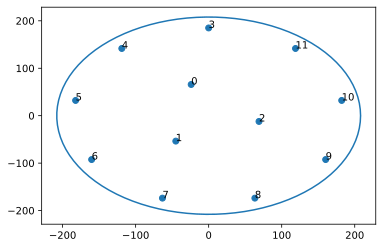

In [1938]:
plt.scatter(xpmt, ypmt)
for x, y, sid  in zip(xpmt, ypmt, sensorids):
    plt.annotate(sid, (x, y))

r = 208
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

In [1877]:
filename = lt_filenames[0]
print(filename)
parts = pd.read_hdf(filename, 'MC/particles')
parts = parts[['event_id', 'initial_x', 'initial_y', 'initial_z']]
display(parts.head(10))


../files/S1_temp/NEW_S1_LT_1.next.h5


,event_id,initial_x,initial_y,initial_z
0,100,-64.291519,-33.851116,357.888550
1,101,-57.908047,-182.549515,220.690140
2,102,55.742599,-124.422577,305.358887
3,103,29.687824,103.638870,499.422363
4,104,128.246384,124.344307,277.658386
5,105,104.762199,68.912193,124.475212
6,106,-93.461655,176.153412,21.139490
7,107,34.848850,-159.153793,375.195526
8,108,-23.086290,-59.359562,367.774689
9,109,-135.283295,-69.965630,196.349304


In [1878]:
# Get the metadata from the files
configuration = pd.read_hdf(filename, "MC/configuration").set_index("param_key")
num_events = int(configuration.loc["num_events"][0])
nphotons   = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])

sns_response  = pd.read_hdf(filename, "MC/sns_response")
pmt_response  = sns_response[np.isin(sns_response["sensor_id"].values, datapmt["SensorID"].values)]

pd.set_option('display.max_rows', None)
# display(pmt_response)
display(pmt_response.head(10))

,event_id,sensor_id,time_bin,charge
344,100,5,0,1008
345,100,5,1,1
346,100,2,0,1393
347,100,2,1,1
348,100,1,0,1442
349,100,1,1,2
350,100,7,0,1079
351,100,3,0,946
352,100,3,1,1
353,100,8,0,939


In [1879]:
# protection time bins
pmt_response = pmt_response.groupby(["sensor_id", "event_id"])["charge"].sum().to_frame().reset_index()
display(pmt_response.head(11))

,sensor_id,event_id,charge
0,0,100,1393
1,0,101,1084
2,0,102,1295
3,0,103,1965
4,0,104,1234
5,0,105,955
6,0,106,700
7,0,107,1401
8,0,108,1452
9,0,109,1072


In [1880]:
# Merge the dataframes to add the x, y, z positions
pmt_response = pmt_response.merge(parts, on="event_id", how = 'inner')
display(pmt_response.head(10))

,sensor_id,event_id,charge,initial_x,initial_y,initial_z
0,0,100,1393,-64.291519,-33.851116,357.88855
1,1,100,1444,-64.291519,-33.851116,357.88855
2,2,100,1394,-64.291519,-33.851116,357.88855
3,3,100,947,-64.291519,-33.851116,357.88855
4,4,100,974,-64.291519,-33.851116,357.88855
5,5,100,1009,-64.291519,-33.851116,357.88855
6,6,100,994,-64.291519,-33.851116,357.88855
7,7,100,1079,-64.291519,-33.851116,357.88855
8,8,100,943,-64.291519,-33.851116,357.88855
9,9,100,998,-64.291519,-33.851116,357.88855


In [1911]:
# Set the Binning
xmin=-210
xmax=210
xbw=20

zmin=0
zmax=510
zbw=25

xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = xbins
zbins = np.arange(zmin, zmax+zbw, zbw)

xbins_centre = np.arange(xmin+xbw/2, xmax+xbw/2, xbw)
ybins_centre = xbins_centre
zbins_centre = np.arange(zmin+zbw/2, zmax+zbw/2, zbw)

print(zbins)
print(zbins_centre)



[  0  25  50  75 100 125 150 175 200 225 250 275 300 325 350 375 400 425
 450 475 500 525]
[ 12.5  37.5  62.5  87.5 112.5 137.5 162.5 187.5 212.5 237.5 262.5 287.5
 312.5 337.5 362.5 387.5 412.5 437.5 462.5 487.5 512.5]


In [1882]:
# Now bin the x, y, z positions
pmt_response['x'] = pd.cut(x=pmt_response['initial_x'], bins=xbins,labels=xbins_centre, include_lowest=True)
pmt_response['y'] = pd.cut(x=pmt_response['initial_y'], bins=ybins,labels=ybins_centre, include_lowest=True)
pmt_response['z'] = pd.cut(x=pmt_response['initial_z'], bins=zbins,labels=zbins_centre, include_lowest=True)

 # remove the initial x,y,z since we are done with them
pmt_response = pmt_response.drop(columns=['initial_x', 'initial_y', 'initial_z'])

In [1883]:
# Normalise the charge in each PMT by the total number of photons simulated
pmt_response['charge'] = pmt_response['charge']/nphotons

LT = pmt_response

# LT  = pd.pivot_table(pmt_response , values="charge", columns="sensor_id", index=["x", "y", "z"])

display(LT.head(10))

,sensor_id,event_id,charge,x,y,z
0,0,100,0.001393,-70.0,-30.0,375.0
1,1,100,0.001444,-70.0,-30.0,375.0
2,2,100,0.001394,-70.0,-30.0,375.0
3,3,100,0.000947,-70.0,-30.0,375.0
4,4,100,0.000974,-70.0,-30.0,375.0
5,5,100,0.001009,-70.0,-30.0,375.0
6,6,100,0.000994,-70.0,-30.0,375.0
7,7,100,0.001079,-70.0,-30.0,375.0
8,8,100,0.000943,-70.0,-30.0,375.0
9,9,100,0.000998,-70.0,-30.0,375.0


In [1884]:
LT  = pd.DataFrame()
ERR = pd.DataFrame()

for i, filename in enumerate(lt_filenames, 1):
    sys.stdout.write(f"Processing file {i}/{len(lt_filenames)} \r")
    sys.stdout.flush()
    
    configuration = pd.read_hdf(filename, "MC/configuration").set_index("param_key")
    num_events = int(configuration.loc["num_events"][0])
    nphotons   = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])

    sns_response  = pd.read_hdf(filename, "MC/sns_response")
    pmt_response  = sns_response[np.isin(sns_response["sensor_id"].values, datapmt["SensorID"].values)]
    
    # protection time bins
    pmt_response = pmt_response.groupby(["sensor_id", "event_id"])["charge"].sum().to_frame().reset_index()

    # Load in the MC Particles
    parts = pd.read_hdf(filename, 'MC/particles')
    parts = parts[['event_id', 'initial_x', 'initial_y', 'initial_z']]

    # Merge the dataframes
    pmt_response = pmt_response.merge(parts, on="event_id", how = 'inner')

    # Now bin the x, y, z positions
    pmt_response['x'] = pd.cut(x=pmt_response['initial_x'], bins=xbins,labels=xbins_centre, include_lowest=True)
    pmt_response['y'] = pd.cut(x=pmt_response['initial_y'], bins=ybins,labels=ybins_centre, include_lowest=True)
    pmt_response['z'] = pd.cut(x=pmt_response['initial_z'], bins=zbins,labels=zbins_centre, include_lowest=True)

    # remove the initial x,y,z since we are done with them
    pmt_response = pmt_response.drop(columns=['initial_x', 'initial_y', 'initial_z'])

    # Normalise the charge in each PMT by the total number of photons simulated
    pmt_response['charge'] = pmt_response['charge']/nphotons
    
    LT  = pd.concat([LT , pmt_response])
    ERR = pd.concat([LT, pmt_response])



In [1885]:
lt = LT.groupby(["sensor_id", "x", "y", "z"])["charge"].mean().to_frame().reset_index()
err = ERR.groupby(["sensor_id", "x", "y", "z"])["charge"].std().to_frame().reset_index()

# Calculate error values
err['charge'] = 100*err['charge']/lt['charge']

display(lt.head(10))
display(err.head(10))

,sensor_id,x,y,z,charge
0,0,-190.0,-190.0,25.0,NaN
1,0,-190.0,-190.0,75.0,NaN
2,0,-190.0,-190.0,125.0,NaN
3,0,-190.0,-190.0,175.0,NaN
4,0,-190.0,-190.0,225.0,NaN
5,0,-190.0,-190.0,275.0,NaN
6,0,-190.0,-190.0,325.0,NaN
7,0,-190.0,-190.0,375.0,NaN
8,0,-190.0,-190.0,425.0,NaN
9,0,-190.0,-190.0,475.0,NaN


,sensor_id,x,y,z,charge
0,0,-190.0,-190.0,25.0,NaN
1,0,-190.0,-190.0,75.0,NaN
2,0,-190.0,-190.0,125.0,NaN
3,0,-190.0,-190.0,175.0,NaN
4,0,-190.0,-190.0,225.0,NaN
5,0,-190.0,-190.0,275.0,NaN
6,0,-190.0,-190.0,325.0,NaN
7,0,-190.0,-190.0,375.0,NaN
8,0,-190.0,-190.0,425.0,NaN
9,0,-190.0,-190.0,475.0,NaN


In [1886]:
LT  = pd.pivot_table(lt, values="charge", columns="sensor_id", index=["x", "y", "z"])
display(LT.head(10))

sensor_id                 0         1         2         3         4   \
x      y     z                                                         
-190.0 -90.0 25.0   0.000679  0.000660  0.000689  0.000574  0.000598   
             75.0   0.000844  0.000847  0.000814  0.000648  0.000736   
             125.0  0.001017  0.000884  0.000989  0.000716  0.000788   
             225.0  0.001035  0.001051  0.001092  0.000789  0.000882   
             325.0  0.001330  0.001355  0.001291  0.000965  0.000965   
             425.0  0.001434  0.001771  0.001453  0.000940  0.001062   
       -70.0 75.0   0.000771  0.000786  0.000807  0.000626  0.000690   
             125.0  0.000939  0.000927  0.000998  0.000724  0.000789   
             225.0  0.001149  0.001110  0.001141  0.000862  0.000904   
             325.0  0.001274  0.001334  0.001258  0.000962  0.001029   

sensor_id                 5         6         7         8         9   \
x      y     z                                                         
-190.0 -90.0 25.0   0.000569  0.000512  0.000585  0.000605  0.000553   
             75.0   0.000700  0.000649  0.000735  0.000724  0.000682   
             125.0  0.000810  0.000746  0.000801  0.000813  0.000722   
             225.0  0.000857  0.000869  0.000851  0.000848  0.000831   
             325.0  0.001099  0.001092  0.001070  0.000979  0.000971   
             425.0  0.001347  0.001459  0.001282  0.001045  0.000947   
       -70.0 75.0   0.000641  0.000605  0.000707  0.000695  0.000657   
             125.0  0.000759  0.000705  0.000745  0.000743  0.000724   
             225.0  0.000920  0.000884  0.000944  0.000860  0.000876   
             325.0  0.001065  0.001025  0.001049  0.000932  0.000952   

sensor_id                 10        11  
x      y     z                          
-190.0 -90.0 25.0   0.000579  0.000520  
             75.0   0.000612  0.000638  
             125.0  0.000771  0.000728  
             225.0  0.000811  0.000798  
             325.0  0.000911  0.000940  
             425.0  0.000961  0.000893  
       -70.0 75.0   0.000644  0.000574  
             125.0  0.000704  0.000692  
             225.0  0.000815  0.000844  
             325.0  0.000952  0.000908

In [1887]:
ERR  = pd.pivot_table(err, values="charge", columns="sensor_id", index=["x", "y", "z"])
display(ERR.head(10))

sensor_id                 0         1         2         3         4   \
x      y     z                                                         
-190.0 -90.0 325.0  3.934278  2.191770  2.081337  1.465506  3.224114   
       -70.0 325.0  3.006392  5.474316  4.543580  6.499686  4.714925   
             75.0   0.000000  0.000000  0.000000  0.000000  0.000000   
             125.0  0.150608  1.602724  0.850229  1.073592  5.377238   
             175.0  0.659615  0.198533  1.708622  5.663719  6.519424   
             225.0  1.187680  6.905781  4.342413  2.612142  7.946914   
             275.0  0.171836  0.910927  6.768578  2.166518  0.282843   
             475.0  3.290966  1.055675  5.359993  0.227001  0.488081   
       -50.0 325.0  2.990685  3.431345  1.645334  4.270190  4.253653   
             75.0   2.802671  8.247861  8.137377  4.584204  6.295354   

sensor_id                  5          6         7         8         9   \
x      y     z                                                           
-190.0 -90.0 325.0   0.128682   2.135883  0.660847  3.248576  1.019515   
       -70.0 325.0   3.568605   3.480890  2.870967  3.596469  3.771916   
             75.0    0.000000   0.000000  0.000000  0.000000  0.000000   
             125.0   0.093224   3.610758  6.074474  3.806766  3.806372   
             175.0   2.769574   0.962050  1.618093  0.671835  6.428243   
             225.0   3.369565   4.429134  2.264572  2.668704  3.153070   
             275.0   0.295861   1.989774  3.401888  1.483714  1.271203   
             475.0  10.787213  10.482715  0.055612  0.333384  1.201881   
       -50.0 325.0   0.936719   0.924776  2.114972  2.608696  6.478373   
             75.0   10.115558   5.256603  5.716339  2.115482  9.056475   

sensor_id                 10        11  
x      y     z                          
-190.0 -90.0 325.0  8.775735  2.708069  
       -70.0 325.0  3.505247  4.434297  
             75.0   0.000000  0.000000  
             125.0  8.744604  5.820229  
             175.0  2.577762  4.959153  
             225.0  3.680158  2.894974  
             275.0  2.697410  1.308744  
             475.0  2.869419  0.876414  
       -50.0 325.0  6.680616  1.338036  
             75.0   4.863793  8.417785

In [1888]:
LT.columns = LT.columns.rename("")
ERR.columns = ERR.columns.rename("")

LT  = LT.reset_index()
display(lt.head(10))
ERR = ERR.reset_index()

,sensor_id,x,y,z,charge
0,0,-190.0,-190.0,25.0,NaN
1,0,-190.0,-190.0,75.0,NaN
2,0,-190.0,-190.0,125.0,NaN
3,0,-190.0,-190.0,175.0,NaN
4,0,-190.0,-190.0,225.0,NaN
5,0,-190.0,-190.0,275.0,NaN
6,0,-190.0,-190.0,325.0,NaN
7,0,-190.0,-190.0,375.0,NaN
8,0,-190.0,-190.0,425.0,NaN
9,0,-190.0,-190.0,475.0,NaN


In [1889]:
pmt = "PmtR11410"
signal_type = "S1"

for sid in sensorids:
    LT = LT.rename({sid: pmt + f"_{sid}"}, axis=1)
    ERR = ERR.rename({sid: pmt + f"_{sid}"}, axis=1)
LT[pmt + f"_total"] = LT.loc[:, LT.columns.difference(["x", "y", "z"])].sum(axis=1)
ERR[pmt + f"_total"] = ERR.loc[:, ERR.columns.difference(["x", "y", "z"])].sum(axis=1)

if signal_type == "S2":
    LT = LT.drop("z", axis=1)

display(LT.tail(10))

,x,y,z,PmtR11410_0,PmtR11410_1,PmtR11410_2,PmtR11410_3,PmtR11410_4,PmtR11410_5,PmtR11410_6,PmtR11410_7,PmtR11410_8,PmtR11410_9,PmtR11410_10,PmtR11410_11,PmtR11410_total
3473,190.0,70.0,275.0,0.001241,0.001240,0.001286,0.000976,0.000927,0.000890,0.000923,0.000908,0.000908,0.001030,0.000971,0.001015,0.012315
3474,190.0,70.0,475.0,0.001486,0.001373,0.001811,0.001154,0.000934,0.000904,0.000922,0.000855,0.001008,0.001361,0.001602,0.001508,0.014918
3475,190.0,70.0,375.0,0.001375,0.001352,0.001464,0.001047,0.000977,0.000952,0.000938,0.000978,0.001019,0.001143,0.001152,0.001155,0.013552
3476,190.0,90.0,25.0,0.000726,0.000793,0.000736,0.000623,0.000603,0.000590,0.000551,0.000567,0.000627,0.000652,0.000580,0.000616,0.007664
3477,190.0,90.0,75.0,0.000839,0.000862,0.000826,0.000675,0.000678,0.000655,0.000661,0.000610,0.000694,0.000693,0.000649,0.000677,0.008518
3478,190.0,90.0,125.0,0.000993,0.000969,0.000914,0.000845,0.000732,0.000728,0.000663,0.000724,0.000802,0.000785,0.000725,0.000762,0.009642
3479,190.0,90.0,225.0,0.001159,0.001155,0.001226,0.000987,0.000918,0.000891,0.000884,0.000894,0.000960,0.000943,0.000892,0.000951,0.011860
3480,190.0,90.0,475.0,0.001576,0.001334,0.001835,0.001222,0.000933,0.000857,0.000875,0.000873,0.000989,0.001260,0.001914,0.001717,0.015386
3481,190.0,90.0,525.0,0.001588,0.001286,0.001935,0.001196,0.000935,0.000811,0.000798,0.000874,0.001014,0.001331,0.002013,0.001775,0.015556
3482,190.0,90.0,375.0,0.001447,0.001328,0.001608,0.001120,0.000975,0.000957,0.000923,0.000892,0.001003,0.001150,0.001257,0.001228,0.013888


In [1890]:
save = True
outfilename = f"NEW-MC_{signal_type}_LT.h5"

if save:
    with tb.open_file(outfilename, 'w') as h5out:
        df_writer(h5out, LT, "LT", "LightTable")

In [1891]:
if save:
    with tb.open_file(outfilename, 'r+') as h5out:
        df_writer(h5out, ERR, "LT", "Error")

In [1892]:
# create config
config = { "detector"   : "new"
         , "ACTIVE_rad" : str(208)
         , "EL_GAP"     : str(6.0)
         , "table_type" : "energy"
         , "signal_type": signal_type
         , "sensor"     : pmt
         , "pitch_x"    : str(10)
         , "pitch_y"    : str(10)}

config = pd.DataFrame({"parameter": config.keys(), "value": config.values()})
if save:
    with tb.open_file(outfilename, 'r+') as h5out:
        df_writer(h5out, config, "LT", "Config")

In [1912]:
lt     = load_dst("../LT/NEW-MC_S1_LT_heavyfiles.h5", "LT", "LightTable")
err    = load_dst("../LT/NEW-MC_S1_LT_heavyfiles.h5", "LT", "Error")
config = load_dst("../LT/NEW-MC_S1_LT_heavyfiles.h5", "LT", "Config")

# lt     = load_dst(outfilename, "LT", "LightTable")
# err    = load_dst(outfilename, "LT", "Error")
# config = load_dst(outfilename, "LT", "Config")

In [1913]:
display(lt.head(10))
display(config)

,x,y,z,PmtR11410_0,PmtR11410_1,PmtR11410_2,PmtR11410_3,PmtR11410_4,PmtR11410_5,PmtR11410_6,PmtR11410_7,PmtR11410_8,PmtR11410_9,PmtR11410_10,PmtR11410_11,PmtR11410_total
0,-200.0,-80.0,12.5,0.000525,0.000523,0.000539,0.000451,0.000494,0.000471,0.000453,0.000499,0.000476,0.000425,0.000413,0.000418,0.005686
1,-200.0,-80.0,37.5,0.000753,0.000759,0.000763,0.000609,0.000648,0.000629,0.000596,0.000650,0.000646,0.000597,0.000582,0.000588,0.007819
2,-200.0,-80.0,62.5,0.000843,0.000835,0.000822,0.000665,0.000690,0.000698,0.000659,0.000695,0.000682,0.000652,0.000619,0.000624,0.008483
3,-200.0,-80.0,87.5,0.000863,0.000849,0.000872,0.000680,0.000729,0.000710,0.000670,0.000742,0.000698,0.000686,0.000669,0.000674,0.008842
4,-200.0,-80.0,112.5,0.000902,0.000891,0.000914,0.000726,0.000764,0.000751,0.000700,0.000753,0.000743,0.000707,0.000706,0.000694,0.009251
5,-200.0,-80.0,137.5,0.000970,0.000961,0.000976,0.000767,0.000796,0.000778,0.000762,0.000791,0.000772,0.000755,0.000759,0.000748,0.009835
6,-200.0,-80.0,162.5,0.001021,0.001028,0.001033,0.000782,0.000824,0.000824,0.000787,0.000821,0.000800,0.000791,0.000766,0.000777,0.010254
7,-200.0,-80.0,187.5,0.001082,0.001083,0.001069,0.000823,0.000853,0.000839,0.000825,0.000876,0.000833,0.000812,0.000801,0.000800,0.010696
8,-200.0,-80.0,212.5,0.001098,0.001088,0.001113,0.000865,0.000858,0.000886,0.000856,0.000883,0.000867,0.000832,0.000836,0.000829,0.011012
9,-200.0,-80.0,237.5,0.001170,0.001159,0.001155,0.000884,0.000912,0.000913,0.000905,0.000905,0.000885,0.000854,0.000850,0.000865,0.011458


,parameter,value
0,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '208', '6.0'"
1,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '208', '6.0'"
2,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '208', '6.0'"
3,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '208', '6.0'"
4,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '208', '6.0'"
5,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '208', '6.0'"
6,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '208', '6.0'"
7,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '208', '6.0'"


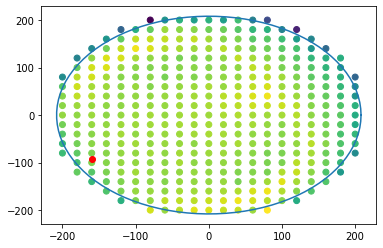

In [1915]:
z =12.5
sel = lt.z == z

sid = 6

plt.scatter(lt[sel].x, lt[sel].y, c=lt[sel][pmt + f"_{sid}"])
plt.scatter(datapmt[datapmt["SensorID"]==sid].X, datapmt[datapmt["SensorID"]==sid].Y, c="r")

# r = float(config.set_index("parameter").loc["ACTIVE_rad"])
r = 208
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

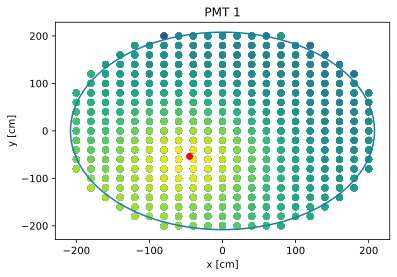

In [1934]:
sid = 1
plt.scatter(lt.x, lt.y, c=lt[pmt + f"_{sid}"])
plt.scatter(datapmt[datapmt["SensorID"]==sid].X, datapmt[datapmt["SensorID"]==sid].Y, c="r")
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.title(f"PMT {sid}")

# r = float(config.set_index("parameter").loc["ACTIVE_rad"])
r = 208
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

Text(0.5, 0.92, 'PMT 0')

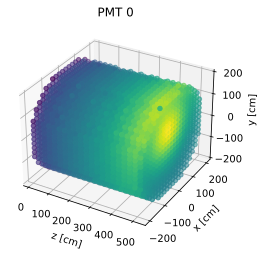

In [1948]:
sid = 0

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(lt.z, lt.x, lt.y, c=lt[pmt + f"_{sid}"])
ax.set_zlim(-200, 200)
ax.scatter([520], [datapmt[datapmt["SensorID"]==sid].X.iloc[0]], [datapmt[datapmt["SensorID"]==sid].Y.iloc[0]], c="r")
ax.set_xlabel("z [cm]")
ax.set_ylabel("x [cm]")
ax.set_zlabel("y [cm]")
ax.set_title(f"PMT {sid}")


In [1919]:
from invisible_cities.core.core_functions import binedges_from_bincenters
xbins = binedges_from_bincenters(np.unique(lt["x"]))
ybins = binedges_from_bincenters(np.unique(lt["y"]))

In [1899]:
display(lt.head(10))

,x,y,z,PmtR11410_0,PmtR11410_1,PmtR11410_2,PmtR11410_3,PmtR11410_4,PmtR11410_5,PmtR11410_6,PmtR11410_7,PmtR11410_8,PmtR11410_9,PmtR11410_10,PmtR11410_11,PmtR11410_total
0,-190.0,-90.0,25.0,0.000679,0.000660,0.000689,0.000574,0.000598,0.000569,0.000512,0.000585,0.000605,0.000553,0.000579,0.000520,0.007123
1,-190.0,-90.0,75.0,0.000844,0.000847,0.000814,0.000648,0.000736,0.000700,0.000649,0.000735,0.000724,0.000682,0.000612,0.000638,0.008629
2,-190.0,-90.0,125.0,0.001017,0.000884,0.000989,0.000716,0.000788,0.000810,0.000746,0.000801,0.000813,0.000722,0.000771,0.000728,0.009785
3,-190.0,-90.0,225.0,0.001035,0.001051,0.001092,0.000789,0.000882,0.000857,0.000869,0.000851,0.000848,0.000831,0.000811,0.000798,0.010714
4,-190.0,-90.0,325.0,0.001330,0.001355,0.001291,0.000965,0.000965,0.001099,0.001092,0.001070,0.000979,0.000971,0.000911,0.000940,0.012968
5,-190.0,-90.0,425.0,0.001434,0.001771,0.001453,0.000940,0.001062,0.001347,0.001459,0.001282,0.001045,0.000947,0.000961,0.000893,0.014594
6,-190.0,-70.0,75.0,0.000771,0.000786,0.000807,0.000626,0.000690,0.000641,0.000605,0.000707,0.000695,0.000657,0.000644,0.000574,0.008203
7,-190.0,-70.0,125.0,0.000939,0.000927,0.000998,0.000724,0.000789,0.000759,0.000705,0.000745,0.000743,0.000724,0.000704,0.000692,0.009449
8,-190.0,-70.0,225.0,0.001149,0.001110,0.001141,0.000862,0.000904,0.000920,0.000884,0.000944,0.000860,0.000876,0.000815,0.000844,0.011309
9,-190.0,-70.0,325.0,0.001274,0.001334,0.001258,0.000962,0.001029,0.001065,0.001025,0.001049,0.000932,0.000952,0.000952,0.000908,0.012741


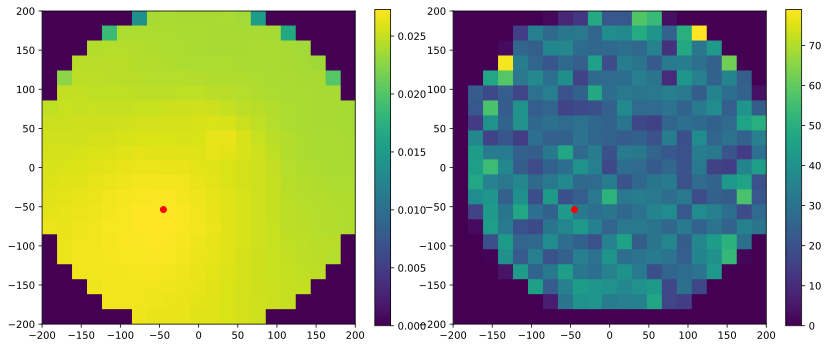

In [1929]:
sensor_id = 1

sensor_name = "PmtR11410_"+str(sensor_id)


fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[12, 5])
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)

# light table
h, _, _ = np.histogram2d(lt["x"], lt["y"], weights=lt[sensor_name], bins=[xbins, ybins])
im0 = ax0.imshow(np.flip(h.T, axis=0), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
ax0.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
fig.colorbar(im0, ax=ax0)

# err
h, _, _ = np.histogram2d(ERR["x"], ERR["y"], weights=ERR[sensor_name], bins=[xbins, ybins])
im1 = ax1.imshow(np.flip(h.T, axis=0), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
ax1.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
fig.colorbar(im1, ax=ax1)

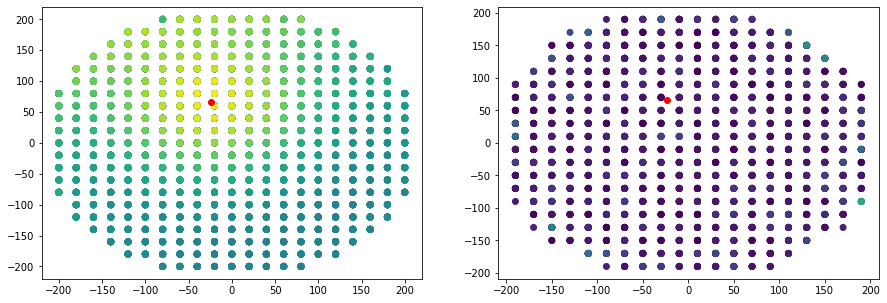

In [1921]:
sensor_id = 0

sensor_name = "PmtR11410_"+str(sensor_id)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=[15, 5])
ax0.scatter(lt["x"], lt["y"], c=lt[sensor_name])
ax1.scatter(ERR["x"], ERR["y"], c=ERR[sensor_name])

ax0.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
ax1.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")

In [1902]:
old_table = os.path.expandvars("$LUSTRE/NEXT100/LightTables/NEXT100_S2_LT.h5")

from invisible_cities.io.dst_io import load_dst
old = load_dst(old_table, "LT", "LightTable")

OSError: ``$LUSTRE/NEXT100/LightTables/NEXT100_S2_LT.h5`` does not exist

In [ ]:
sensor_id = 31

fig, (ax0, ax1) = plt.subplots(1,2, figsize=[15, 5])

ax0.set_title("new")
ax0.scatter(lt["x"], lt["y"], c=lt[sensor_id])


ax1.set_title("old")
ax1.scatter(old["x"], old["y"], c=old[f"PmtR11410_{sensor_id}"], s=3)


plt.figure()
_, bins, _ = plt.hist(old[f"PmtR11410_{sensor_id}"], bins=100 , density=True, histtype="step", linewidth=2)
_, _   , _ = plt.hist(lt[sensor_id]                , bins=bins, density=True, alpha=0.5);